In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, learning_curve
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score

In [3]:
labels_training = pd.read_csv('./../../labels/labels_v3/labels_v3_training_set.csv', index_col=0)
labels_test = pd.read_csv('./../../labels/labels_v3/labels_v3_test_set.csv', index_col=0)
features = pd.read_csv('./../../models/model_logistic_regression_v5/manually_selected_features_frac.csv', index_col=0)

print(list(features))

['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_s

## Merge features and labels

In [12]:
labels_features_training = pd.merge(features, labels_training, on='SAMPLE_ID', how='inner')
labels_features_training

labels_features_test = pd.merge(features, labels_test, on='SAMPLE_ID', how='inner')
labels_features_test


labels_features_training = labels_features_training.set_index('SAMPLE_ID', inplace=False)
labels_features_test = labels_features_test.set_index('SAMPLE_ID', inplace=False)
labels_features_training.to_excel('merged_features_and_labels_v3_training.xlsx')
labels_features_test.to_excel('merged_features_and_labels_v3_test.xlsx')

## Sixth model run - labels v3, manually selected features

In [24]:
columns_to_drop = ['labels_v3']

# Training set definition

X_train = labels_features_training.drop(columns_to_drop, axis=1)
y_train = labels_features_training['labels_v3']


# Test set definition

X_test = labels_features_test.drop(columns_to_drop, axis=1)
y_test = labels_features_test['labels_v3']

original_training_indices = labels_features_training.index
original_test_indices = labels_features_test.index
X_train.index = original_training_indices
y_train.index = original_training_indices
X_test.index = original_test_indices
y_test.index = original_test_indices

### Features normalization

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(127, 58)
(69, 58)


### Model training

In [36]:
model = LogisticRegression()
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean precision:", scores.mean())

Cross-validation scores: [0.76923077 0.69230769 0.46153846 0.84615385 0.66666667]
Mean precision: 0.6871794871794872


### Model testing

In [32]:
y_pred = model.predict(X_test)

y_pred_list = pd.DataFrame(y_pred, columns=['Predicted'], index=original_test_indices)
y_pred_list
y_pred_list.to_excel('predicted_labels_test_set_v6.xlsx')

,Predicted
SAMPLE_ID,
Sample_0003,0
Sample_0013,1
Sample_0015,0
Sample_0016,0
Sample_0018,1
...,...
Sample_0248,1
Sample_0249,1
Sample_0251,1


## Model evaluation

In [33]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"AUC: {roc_auc}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(cr)

Accuracy: 0.6811594202898551
AUC: 0.6059322033898304
Confusion Matrix:
[[ 5  5]
 [17 42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.50      0.31        10
           1       0.89      0.71      0.79        59

    accuracy                           0.68        69
   macro avg       0.56      0.61      0.55        69
weighted avg       0.80      0.68      0.72        69



<Axes: >

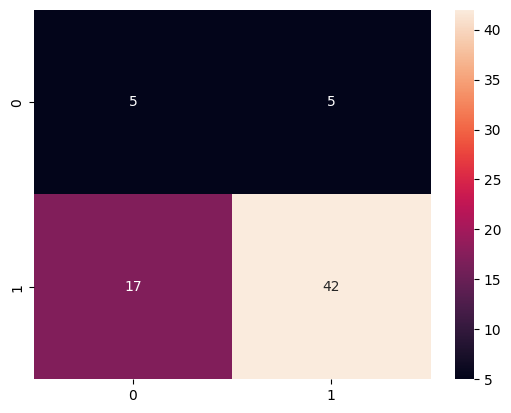

In [34]:
import seaborn as sns
sns.heatmap(cm, annot=True)

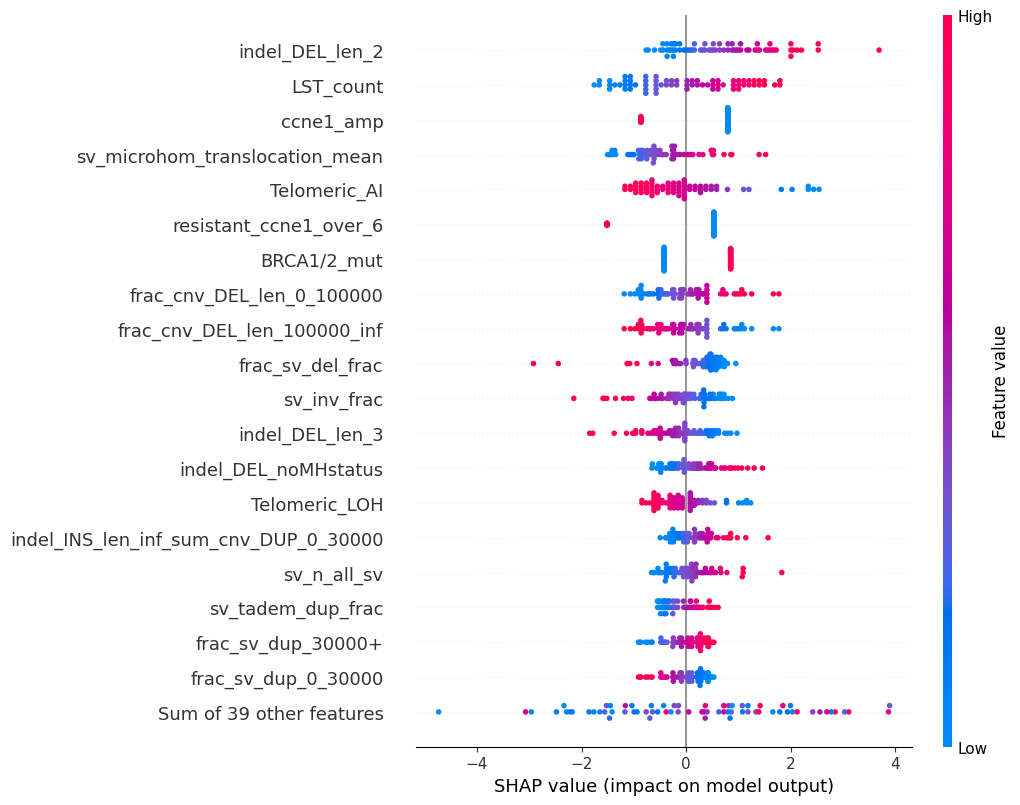

In [35]:
import shap

original_feature_names = ['BRCA1/2_mut', 'other_HRR_gene_mutation_somatic', 'sv_trans_frac', 'sv_del_frac', 'sv_inv_frac', 'sv_tadem_dup_frac', 'sv_n_all_sv', 'sv_n_svclass_stdev', 'sv_microhom_deletion_mean', 'sv_microhom_inversion_mean', 'sv_microhom_tandem-duplication_mean', 'sv_microhom_translocation_mean', 'indel_n_del', 'indel_n_ins', 'ins_indel_ratio', 'del_indel_ratio', 'indel_DEL_len_1', 'indel_DEL_len_2', 'indel_DEL_len_3', 'indel_DEL_len_4', 'indel_DEL_len_inf', 'indel_INS_len_1', 'indel_INS_len_2', 'indel_INS_len_3', 'indel_INS_len_4', 'indel_INS_len_inf', 'indel_DEL_mh', 'indel_DEL_noMHstatus', 'indel_DEL_rep', 'indel_del_mh_ratio', 'Telomeric_AI', 'Interstitial_AI', 'Telomeric_LOH', 'Interstitial_LOH', 'LST_count', 'LOH_count', 'MSI', 'cnv_DEL_0_3500_sum_indel_DEL_len_inf', 'indel_INS_len_inf_sum_cnv_DUP_0_30000', 'indel_INS_len_inf_sum_cnv_DUP_0_1000', 'frac_cnv_DUP_len_30000_inf', 'frac_cnv_DEL_len_100000_inf', 'frac_cnv_DIPLOID_len_100000_inf', 'frac_sv_dup_30000+', 'frac_sv_del_frac', 'frac_sv_del_100000+', 'FBI_relaxed', 'percent_all_cc2ca', 'percent_all_cc2ct', 'cc2ca_vs_cc2ct', 'SBS31', 'ccne1_amp', 'resistant_ccne1_over_6', 'frac_cnv_DUP_len_0_30000', 'frac_cnv_DEL_len_0_100000', 'frac_cnv_DIPLOID_len_0_100000', 'frac_sv_dup_0_30000', 'frac_sv_del_0_100000']
X_train_features = pd.DataFrame(X_train, columns=original_feature_names)
X_test_features = pd.DataFrame(X_test, columns=original_feature_names)

explainer = shap.Explainer(model, X_train_features)
shap_values = explainer(X_test_features)
shap.plots.beeswarm(shap_values, max_display=20)